In [28]:
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import collections
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV
import datetime, time
import pytz
import statsmodels.api as stats_api

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
pp = pprint.PrettyPrinter(indent=2)
with open('tweet_data/tweets_#gohawks.txt') as json_data:
    for line in json_data:
        d = json.loads(line)
        pp.pprint(d)
        break

{ 'author': { 'author_img': 'http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg',
              'description': 'Married to my best friend... You-make me laugh '
                             'and occasionally think... I-will let you in on '
                             'some of the crazy shit that consumes my '
                             'thoughts...',
              'followers': 1752.0,
              'image_url': 'http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg',
              'name': 'RJ',
              'nick': 'rejinseattle',
              'type': 'twitter',
              'url': 'http://twitter.com/rejinseattle'},
  'citation_date': 1421518778,
  'citation_url': 'http://twitter.com/REJinseattle/status/556516209261166593',
  'firstpost_date': 1419804875,
  'highlight': 'I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8',
  'metrics': { 'acceleration': 0,
               'citations': { 'data': [ { 'citations': 1,
                 

# 1. Popularity Prediction

#### Initialize variables

In [21]:
hashtags = ['#gopatriots']#,'#nfl','#sb49','#gohawks','#patriots','#superbowl'] using only one tag
df_map = {} # to store dfs for each file

#### Reading files into dataframes and storing

In [25]:
df_columns = ['timestamp','tweet_id','author_id','followers','retweets',
              'firstpost',
              'acceleration','impressions','peak', 'ranking_score', 
              'org_followers', 
              'title', 
              'user_mentions', 
              'favorite_count', 'sensitivity', 'retweet_count']
for hashtag in hashtags:
    df = pd.DataFrame(columns=df_columns)
    lno = 0
    print("Processing ",hashtag)
    with open("tweet_data/tweets_"+hashtag+".txt", "r") as file_obj:
        for line in file_obj:
            if(lno%5000 == 0):
                print(lno)
            j = json.loads(line)
            #pp.pprint(j)
            #must need columns
            timestamp =j['citation_date']
            followers =j['author']['followers']
            retweets = j['metrics']['citations']['total']
            #useful for later
            author_id = j['author']['url']
            tweet_id = j['tweet']['id']
            # additional features
            firstpost = j['firstpost_date']
            acceleration = j['metrics']['acceleration']
            impressions = j['metrics']['impressions']
            peak = j['metrics']['peak']
            ranking_score = j['metrics']['ranking_score']
            org_followers = j['original_author']['followers']
            #influence = j['original_author']['influence_level']
            title = j['title']
            user_mentions = j['tweet']['entities']['user_mentions']
            favorite_count = j['tweet']['favorite_count']
            sensitivity = j['tweet']['possibly_sensitive']
            retweet_count = j['tweet']['retweet_count']
            #df.loc[lno] = [timestamp,author_id, tweet_id,followers,retweets]
            df.loc[lno] = [timestamp, tweet_id, author_id, followers, retweets,
                           firstpost,
                           acceleration, impressions, peak, ranking_score, 
                           org_followers, 
                           title, 
                           user_mentions, 
                           favorite_count, sensitivity, retweet_count]
                        ##
            #print(df.head())
            lno+=1
        df_map[hashtag] = df.copy()     
        

Processing  #gopatriots
0
5000
10000
15000
20000
25000


In [42]:
df_map['#gopatriots'].head()

,timestamp,tweet_id,author_id,followers,retweets,firstpost,acceleration,impressions,peak,ranking_score,org_followers,title,user_mentions,favorite_count,sensitivity,retweet_count
0,1421257541,553650101105606656,http://twitter.com/patsnation87,2895.0,6,1420835445,0,2695,1421257559,4.640276,3811.0,LeGarrette Blount does the Ray Lewis Dance #Th...,[],0,False,0
1,1421275471,553994483457875968,http://twitter.com/thetrumd,158.0,4,1420917552,0,146,1421275499,3.892707,1163.0,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,"[{'indices': [57, 66], 'id_str': '31126587', '...",0,False,0
2,1421295565,554068000366526464,http://twitter.com/rhry8643828,52.0,33,1420935080,0,30,1421295599,4.096886,15564.0,I don't care what anyone says! Tom Brady is th...,[],0,False,1
3,1421341875,554076243038326785,http://twitter.com/ricciardelli,20896.0,3,1420937045,0,22258,1421341919,3.737522,2124.0,With both my father and husband yelling at the...,[],0,False,1
4,1421285189,554774415914061825,http://twitter.com/soccer44life10,500.0,3,1421103502,0,482,1421285219,3.952203,1216.0,The girls soccer team is ranked the No. 3 team...,[],1,False,1


In [41]:
df_map['#gopatriots'].to_csv('#gopatriots.csv', encoding='utf-8', index=False)

## 1.1 Statistics

In [29]:
tweets_hrly = {}
retweets_hrly = {}
followers_hrly = {}
tweets_cnt = {}
retweets_cnt = {}
followers_cnt = {}

for hashtag in hashtags:
    df = df_map[hashtag]
    sec = df['timestamp'].max() - df['timestamp'].min()   
    tweets_cnt[hashtag] = df['tweet_id'].count()
    retweets_cnt[hashtag] = df['retweets'].sum()
    followers_cnt[hashtag] = df['followers'].sum()
    tweets_hrly[hashtag] = (tweets_cnt[hashtag]*3600)/sec
    retweets_hrly[hashtag] = (retweets_cnt[hashtag]*3600)/sec
    followers_hrly[hashtag] = (followers_cnt[hashtag]*3600)/sec    


In [30]:
print('Tweets Count : ',tweets_cnt)
print('Tweets Avg. hourly',tweets_hrly)
print('Retweets Count : ',retweets_cnt)
print('Retweets Avg. hourly',retweets_hrly)

print('Followers Count : ',followers_cnt)
print('Followers Avg. hourly',followers_cnt)

Tweets Count :  {'#gopatriots': 26232}
Tweets Avg. hourly {'#gopatriots': 45.694510573562027}
Retweets Count :  {'#gopatriots': 36727}
Retweets Avg. hourly {'#gopatriots': 63.976147065996216}
Followers Count :  {'#gopatriots': 36774523.0}
Followers Avg. hourly {'#gopatriots': 36774523.0}


## 1.2 Linear Regression

#### K-fold cross validation from our previous project

In [31]:
def perform_10fold(X,y,regressor, print_ = False,shuffle_= True):
    kf = KFold(n_splits=10,shuffle=shuffle_, random_state=0)
    i = 1
    bestModel = None
    tr_e = 0
    ts_e = 0
    min_ts_e = 10
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor.fit(X_train,y_train)
        train_preds = regressor.predict(X_train)
        test_preds = regressor.predict(X_test)
        test_error = mean_squared_error(y_test,test_preds)
        tr_e += mean_squared_error(y_train,train_preds)
        ts_e += test_error
        if(print_):
            print("Fold : ",i)
            print("Training RMSE : ",np.sqrt(mean_squared_error(y_train,train_preds)))
            print("Test RMSE : ",np.sqrt(test_error))
        if(test_error<min_ts_e):
            min_ts_e = test_error
            bestModel = regressor
        i = i+1
    return np.sqrt(tr_e/10),np.sqrt(ts_e/10), bestModel

#### Returns the hour number from timestamp

In [35]:
pst_tz = pytz.timezone('US/Mountain')
def getHourofDay(timestamp):
    #print(timestamp)
    return datetime.datetime.fromtimestamp(timestamp, pst_tz).hour

    
def getHour(timestamp):
    return int(timestamp/3600)

In [36]:
X_map = {}
Y_map = {}
for hashtag in hashtags:
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'followers': ['sum', 'max'],'tweet_id':'count', 'retweets':'sum'})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    #grouped.columns=grouped.columns.droplevel()
    grouped.reset_index(inplace=True)
    grouped['hour_of_day','tweet'] = grouped.apply(lambda x: getHourofDay(x['timestamp']*3600), axis=1)
    X_map[hashtag] = grouped.drop(['timestamp','tweet_id_count'],axis=1)
    Y_map[hashtag] = grouped['tweet_id_count']
    #print(grouped)
    

In [37]:
for hashtag in hashtags:
    model = stats_api.OLS(Y_map['#gopatriots'],X_map['#gopatriots']).fit()
    print(model.summary())
    

                            OLS Regression Results                            
Dep. Variable:         tweet_id_count   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.129e+04
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        21:57:09   Log-Likelihood:                -2216.2
No. Observations:                 447   AIC:                             4440.
Df Residuals:                     443   BIC:                             4457.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
followers_sum           

In [66]:
X_map['#gopatriots'].head()

,followers_sum,followers_max,retweets_sum,"(hour_of_day, tweet)"
0,10955.0,10955.0,4,2
1,1762.0,1762.0,3,3
2,1168.0,600.0,3,5
3,465.0,431.0,3,6
4,2850.0,1425.0,3,7


In [48]:
df_map['#gopatriots'].head()

,timestamp,tweet_id,author_id,followers,retweets,firstpost,acceleration,impressions,peak,ranking_score,org_followers,title,user_mentions,favorite_count,sensitivity,retweet_count
0,1421257541,553650101105606656,http://twitter.com/patsnation87,2895.0,6,1420835445,0,2695,1421257559,4.640276,3811.0,LeGarrette Blount does the Ray Lewis Dance #Th...,[],0,False,0
1,1421275471,553994483457875968,http://twitter.com/thetrumd,158.0,4,1420917552,0,146,1421275499,3.892707,1163.0,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,"[{'indices': [57, 66], 'id_str': '31126587', '...",0,False,0
2,1421295565,554068000366526464,http://twitter.com/rhry8643828,52.0,33,1420935080,0,30,1421295599,4.096886,15564.0,I don't care what anyone says! Tom Brady is th...,[],0,False,1
3,1421341875,554076243038326785,http://twitter.com/ricciardelli,20896.0,3,1420937045,0,22258,1421341919,3.737522,2124.0,With both my father and husband yelling at the...,[],0,False,1
4,1421285189,554774415914061825,http://twitter.com/soccer44life10,500.0,3,1421103502,0,482,1421285219,3.952203,1216.0,The girls soccer team is ranked the No. 3 team...,[],1,False,1


In [ ]:
X_map = {}
Y_map = {}
for hashtag in hashtags:
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp')

In [51]:
type(df_map['#gopatriots']['timestamp'])

pandas.core.series.Series

In [81]:
df = df_map[hashtag].copy()
df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
grouped = df.groupby('timestamp')
X = np.zeros((len(grouped), 14))
Y = np.zeros((len(grouped)))
#hourly_series = df.groupby(pd.TimeGrouper(freq='60Min'))
# Extract features for each hourly interval
for i,(interval,group) in enumerate(grouped):
    X[i, 0] = tweets_cnt[hashtag]                        # Number of tweets
    X[i, 1] = X_map[hashtag]['retweets_sum'].sum()       # Number of retweets
    X[i, 2] = X_map[hashtag]['followers_sum'].sum()      # Sum of follower counts
    X[i, 3] = X_map[hashtag]['followers_max'].max()      # Maximum size following
    X[i, 4] = interval                                   # Hour
    X[i, 5] = group.impressions.sum()/tweets_cnt[hashtag] 
    X[i, 6] = group.favorite_count.sum()/tweets_cnt[hashtag] 
    X[i, 7] = group.ranking_score.sum()/tweets_cnt[hashtag] 
    X[i, 8] = group.author_id.nunique()
    X[i, 9] = len(group.title)
    X[i,10] = len(group.user_mentions)
    X[i,11] = group.sensitivity.mode()[0]
    X[i,12] = getHour(group.peak.max())
    X[i,13] = getHour(group.firstpost.max())
    
    Y[i] = Y_map[hashtag][i]

In [84]:
X = np.nan_to_num(X[:-1])
Y = Y[1:]

In [85]:
stats_api.add_constant(X)
result = stats_api.OLS(Y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     139.4
Date:                Tue, 06 Mar 2018   Prob (F-statistic):          3.62e-115
Time:                        23:03:39   Log-Likelihood:                -2956.2
No. Observations:                 446   AIC:                             5930.
Df Residuals:                     437   BIC:                             5967.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   2.31e-05     11.189      0.0

/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Best features
tweet_id


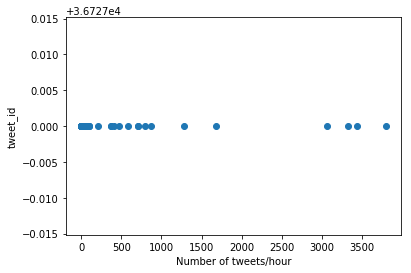

followers


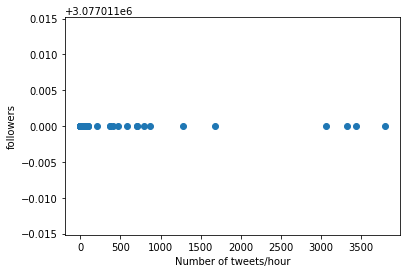

timestamp


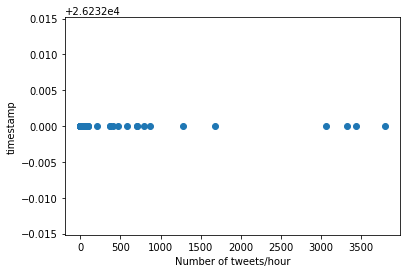

acceleration


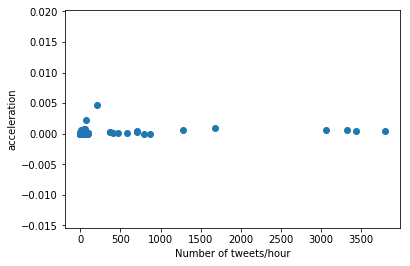

peak


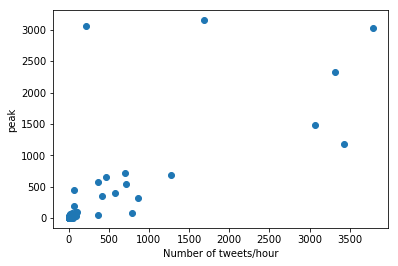

In [102]:
best_features = result.pvalues.argsort()[:5]
print("Best features")
for index in best_features:
    print(df_columns[index])
    plt.xlabel("Number of tweets/hour")
    plt.ylabel(df_columns[index])
    plt.scatter(Y, X[:, index])
    plt.show()